In [1]:
%matplotlib inline
from sensor_data_analysis_api import *

### CLASS: piecewise_linear

**piecewise_linear is the class that performs the piecewise linear approximation on the data. **

1. This class inherits encoder class.
2. compress and recon are overridden from base class.
3. internal method fit() is used to fit the data.


**Constructor:**
- Takes input as series.
- Calls fit() to train the model.

**fit**
- Takes series of values and max_gap as input.
- Uses dynamic programming to create patches of minimized error.
- Error is calculated iteratively by finding the slope for each max_gap.
- values for minimum error is stored in each iteration.

**recon**

- Linear interpolation is performed for reconstruction from the compresseed data.
- numpy interpolation function is used.

**Compress**

- Iteratively stores the time and values for every changing slope

Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_linear model initialized
error = 0.0163576210903 error/_std= 0.00505494767415


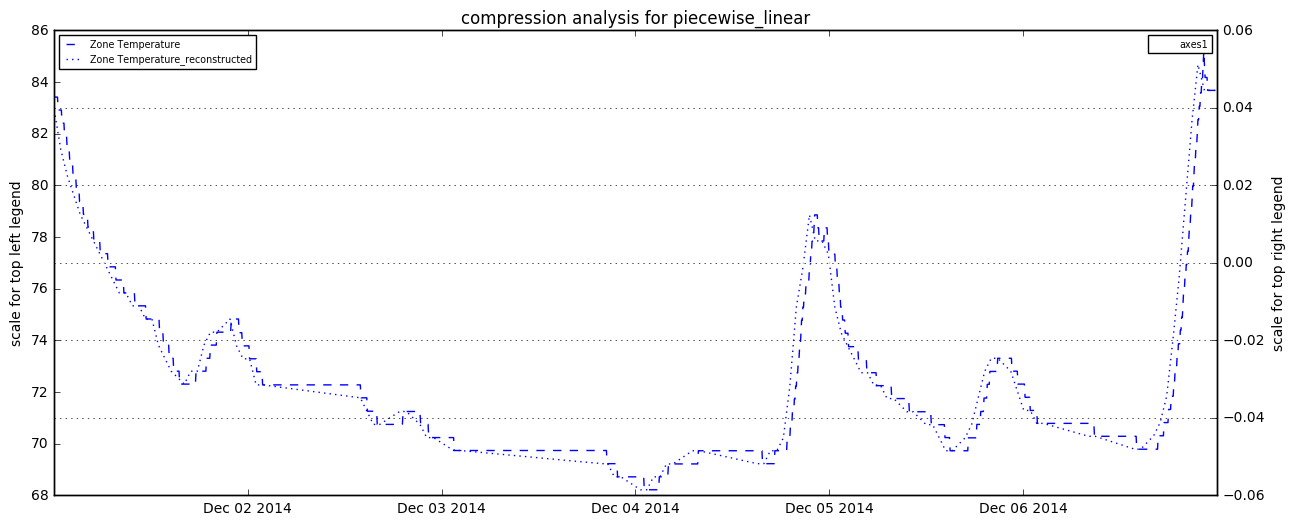

In [2]:
room = 'Rm-4226'
signals = ['Zone Temperature']
method = 'piecewise_linear'
[dfs, plotTemplates] = runAnalysis(room, stTime='2014-12-01', enTime='2014-12-07',
                                   templates = signals, method=method)
plotResults(dfs, plotTemplates, method = method)

### CLASS: piecewise_constant

**piecewise_linear is the class that performs the piecewise constant approximation on the data. **

1. This class inherits encoder class.
2. compress and recon are overridden from base class.
3. internal method fit() is used to fit the data.


**Constructor:**

- Takes input as series.
- Calls fit() to train the model.

**fit**

- Takes series of values and max_gap as input.
- Uses dynamic programming to create patches of minimized error.
- Error is calculated iteratively by finding the error and number of switches.
- values for minimum error is stored in each iteration.

**recon**

- Takes the array of time, value pairs and create a treashold points.
- NaNs are removed and are not interpolated to have constant values.

**Compress**

- Creates an array of {time, value} values based on the current and previous value.

Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_constant model initialized
error = 0.00515153738704 error/_std= 0.00159196449099


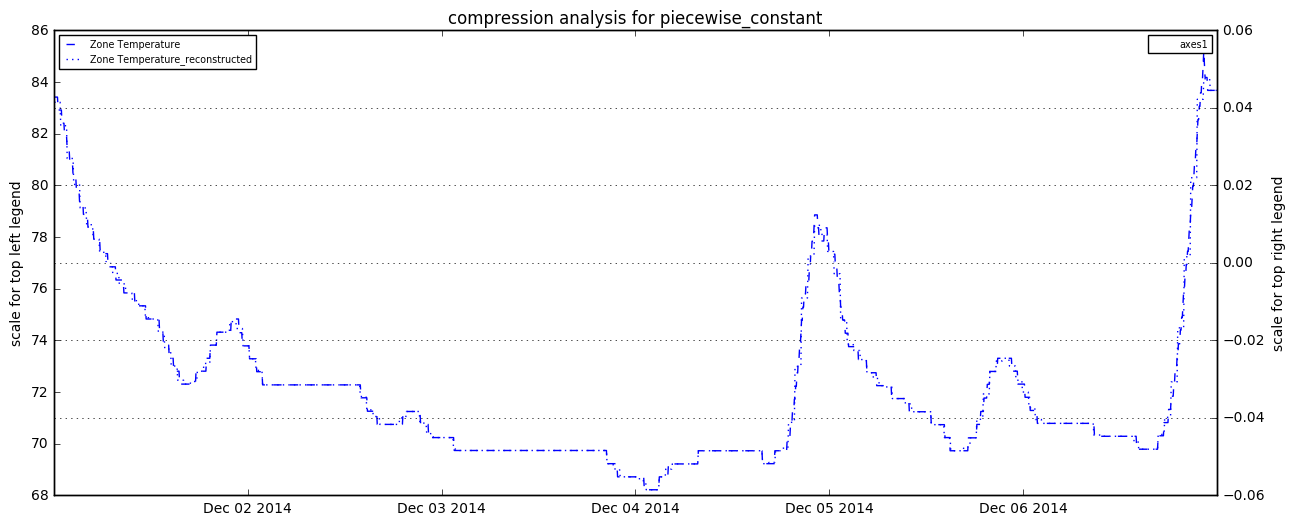

In [3]:
room = 'Rm-4226'
signals = ['Zone Temperature']
method='piecewise_constant'
[dfs, plotTemplates] = runAnalysis(room, stTime='2014-12-01', enTime='2014-12-07',
                                   templates = signals, method = method)
plotResults(dfs, plotTemplates, method=method)

In [4]:
room = 'Rm-4226'
dataDF = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)

Read file:  506_0_3001981.csv
Read file:  506_0_3001987.csv
Read file:  506_0_3001985.csv
Read file:  506_0_3001984.csv
Read file:  506_0_3001986.csv
Read file:  506_1_3001989.csv
Read file:  506_1_3015755.csv
Read file:  506_1_3001991.csv
Read file:  506_1_3001988.csv
Read file:  506_1_3001994.csv
Read file:  506_1_3001993.csv
Read file:  506_1_3001996.csv
Read file:  506_1_3001990.csv
Read file:  506_1_3001992.csv
Read file:  506_1_3001995.csv
Read file:  506_14_3001999.csv


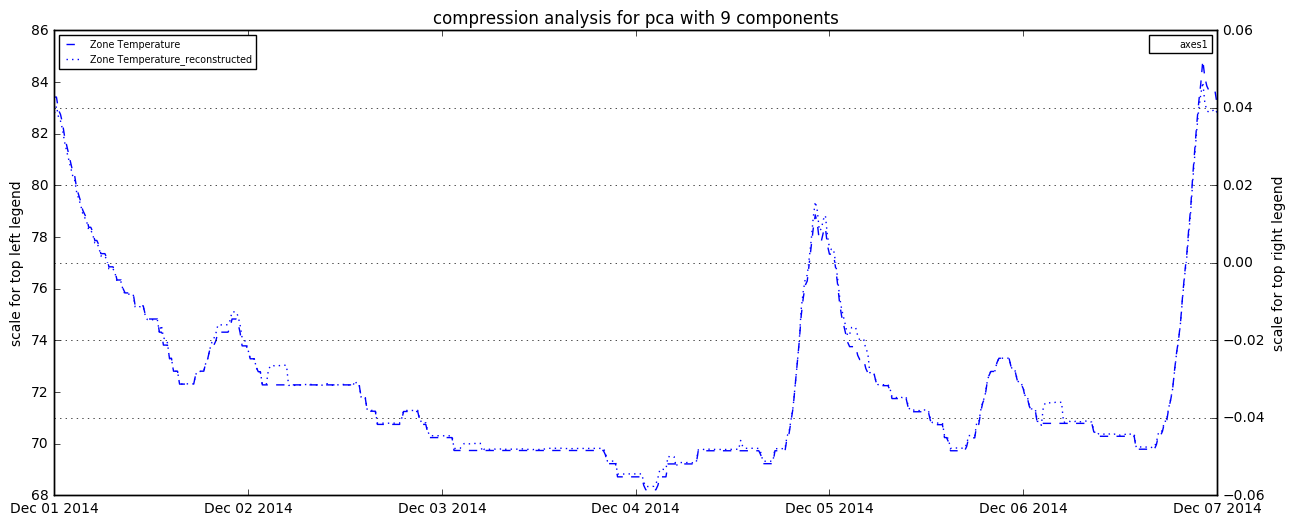

In [5]:
n_components = 9
[dfs, plotTemplates] = CompressWithPCA(dataDF, stTime='2014-12-01', enTime='2014-12-07', n_components = 9)
plotResults(dfs, plotTemplates, method='pca with %d components'%n_components)